In [1]:
import pickle , matplotlib.pyplot as plt, torch, numpy as np, argparse, time, os, scipy
from src.TorchDSP.pbc_new import NonlienarFeatures, FoPBC
from src.TorchDSP.dataloader import  get_signals
from src.TorchSimulation.receiver import  BER



class Model(object):
    def __init__(self, Nmodes, rho, L, index_type):
        self.Nmodes = Nmodes
        self.rho = rho
        self.L = L
        self.index_type = index_type
        self.features = NonlienarFeatures(Nmodes=self.Nmodes, rho=self.rho, L = self.L, index_type=self.index_type)
        self.C = torch.zeros(len(self.features.index), dtype=torch.complex64)

    def scatter(self, figsize=(10,10),dpi=400, s=3):
        x,y = zip(*self.features.index)
        values = np.log10(np.abs(self.C) + 1e-8)
        plt.figure(figsize=figsize, dpi=dpi)
        FoPBC(rho=self.rho, L=self.L, Nmodes=self.Nmodes, index_type=self.index_type).scatter_C(x,y,values, s=s)
        return 

    def scale(self, train_p, test_p):
        return 10**(test_p/10) / 10**(train_p/10)
    
    def fit(self, train_signal, train_truth, train_z, truncation=[0,-1], lamb_l2=0.1):
        s,e = truncation
        E = train_signal.val
        X = torch.squeeze(self.features(E, E, E))[s:e]
        Y = torch.squeeze(train_signal.val - train_truth.val)[s:e]
        A = (X.T.conj() @ X) / X.shape[0] + lamb_l2 * torch.eye(X.shape[1])               # A.eig: 4e5 ~ 1e8
        b = (X.T.conj()) @ Y /X.shape[0]
        self.C = torch.linalg.solve(A, b)
        print('Model fit complete!')
        return 
    
    def get_pbc(self, test_signal, train_p, test_p):
        PBC = (torch.squeeze(self.features(test_signal.val, test_signal.val, test_signal.val)) @ self.C ) * self.scale(train_p, test_p)
        return PBC


    def predict(self, test_signal, train_p, test_p, xi=1):
        return test_signal.val[0,:,0] - xi*self.get_pbc(test_signal, train_p, test_p)

    def test(self, test_signal, truth_signal, train_p, test_p, xi=1, BER_discard=10000):
        Yhat_test = self.predict(test_signal, train_p, test_p, xi=xi)
        return BER(Yhat_test[BER_discard: - BER_discard,None], truth_signal.val[0,BER_discard:-BER_discard])


BER_discard = 10000

# data

- 40G
  
|rho|L| train power | test power | train [s,e]  |  lamb_l2 | Q           | best Q           | 
|---------|---------|---------    |---------   |---------     |--------- |---------    |--------         |
|1|400| 1 | -2 | [2000:-2000] | 0 | 10.61 (xi=1)| 10.66 (xi=1.05)|
|1|400| 1 | -2 | [2000:-4000] | 0.05 | 10.62 (xi=1)| 10.65 (xi=1.05)|
|1|400| 1 | -2 | [10000:-10000] | 0.1 | 10.61 (xi=1)| 10.63 (xi=1.03)|
|1|400| 1 | -2 | [1000:-1000] | 0.1 | 10.61 (xi=1)| 10.65 (xi=1.05)|
|1|400| 1 | -2 | [2000:-4000] | 0.1 | 10.61 (xi=1)| 10.66 (xi=1.05)|
|1|400| 1 | -2 | [2000:-4000] | 0.2 | 10.58 (xi=1)| 10.65 (xi=1.07)|
|1|400| 1 | -1 | [2000:-2000] | 0 | 10.13 (xi=1)| 10.14 (xi=1.10)|
|1|400| 0 | -3 | [2000:-2000] | 0 | 10.46 (xi=1)| 10.48 (xi=0.95)|
|1|400| 0 | -3 | [2000:-2000] | 0.1 | 10.47 (xi=1)| 10.48 (xi=0.99)|
|1|400| -1 | -2 | [2000:-2000] | 0.1 | 10.60 (xi=1)| 10.62 (xi=0.94)|
|1|400| -2 | -2 | [2000:-2000] | 0.1 | 10.56 (xi=1)| 10.57 (xi=0.92)|
|1|400| -2 | -2 | [2000:-2000] | 0 | 10.52 (xi=1)| 10.58 (xi=0.95)|
|1|400| 0 | -2 | [10000:-10000] | 0 | 10.63 (xi=1)| 10.64 (xi=0.99)|
|1|400| 0 | -2 | [1000:-1000] | 0 | 10.63 (xi=1)| 10.64 (xi=0.92)|
|1|400| 0 | -2 | [1000:-1] | 0 | 10.63 (xi=1)| 10.64 (xi=0.92)|
|1|400| 0 | -2 | [0:-2000] | 0 | 10.60 (xi=1)| 10.64 (xi=0.92)|
|1|400| 0 | -2 | [0:-1] | 0 | 10.62 (xi=1)| 10.65 (xi=0.97)|
|1|400| 0 | -2 | [10000:-10000] | 0.01 | 10.64 (xi=1)| 10.64 (xi=0.95)|
|1|400| 0 | -2 | [2000:-4000] | 0.01 | 10.64 (xi=1)| 10.65 (xi=0.92)|
|1|400| 0 | -2 | [0:-1] | 0.1 | 10.64 (xi=1)| 10.65 (xi=0.99)|
|1|400| 0 | -2 | [1000:-1000] | 0.1 | 10.65 (xi=1)| 10.65 (xi=0.99)|
|1|400| 0 | -2 | [10000:-10000] | 0.1 | 10.65 (xi=1)| 10.65 (xi=1.02)|
|1|400| 0 | -2 | [2000:-4000] | 0.1 | 10.67 (xi=1)| 10.67 (xi=0.94)|
|1|400| 0 | -2 | [2000:-4000] | 0.05 | 10.64 (xi=1)| 10.67 (xi=1.04)|
|1|400| 0 | -2 | [10000:-10000] | 0.05 | 10.64 (xi=1)| 10.66 (xi=0.99)|
|1|400| 0 | -2 | [10000:-10000] | 0.2 | 10.65 (xi=1)| 10.67 (xi=1.03)|
|1|400| 0 | -2 | [10000:-10000] | 0.3 | 10.63 (xi=1)| 10.64 (xi=1.05)|
|1|200| 0 | -2 | [2000:-2000] | 0.1 | 10.54 (xi=1)| 10.55 (xi=1.06)|
|1|100| 0 | -2 | [2000:-2000] | 0.1 | 10.08 (xi=1)| 10.09 (xi=1.03)|
|2|100| 0 | -2 | [2000:-2000] | 0.1 | 10.39 (xi=1)| 10.40 (xi=0.97)|
|2|100| 0 | -2 | [2000:-2000] | 0 | 10.37 (xi=1)| 10.39 (xi=0.97)|

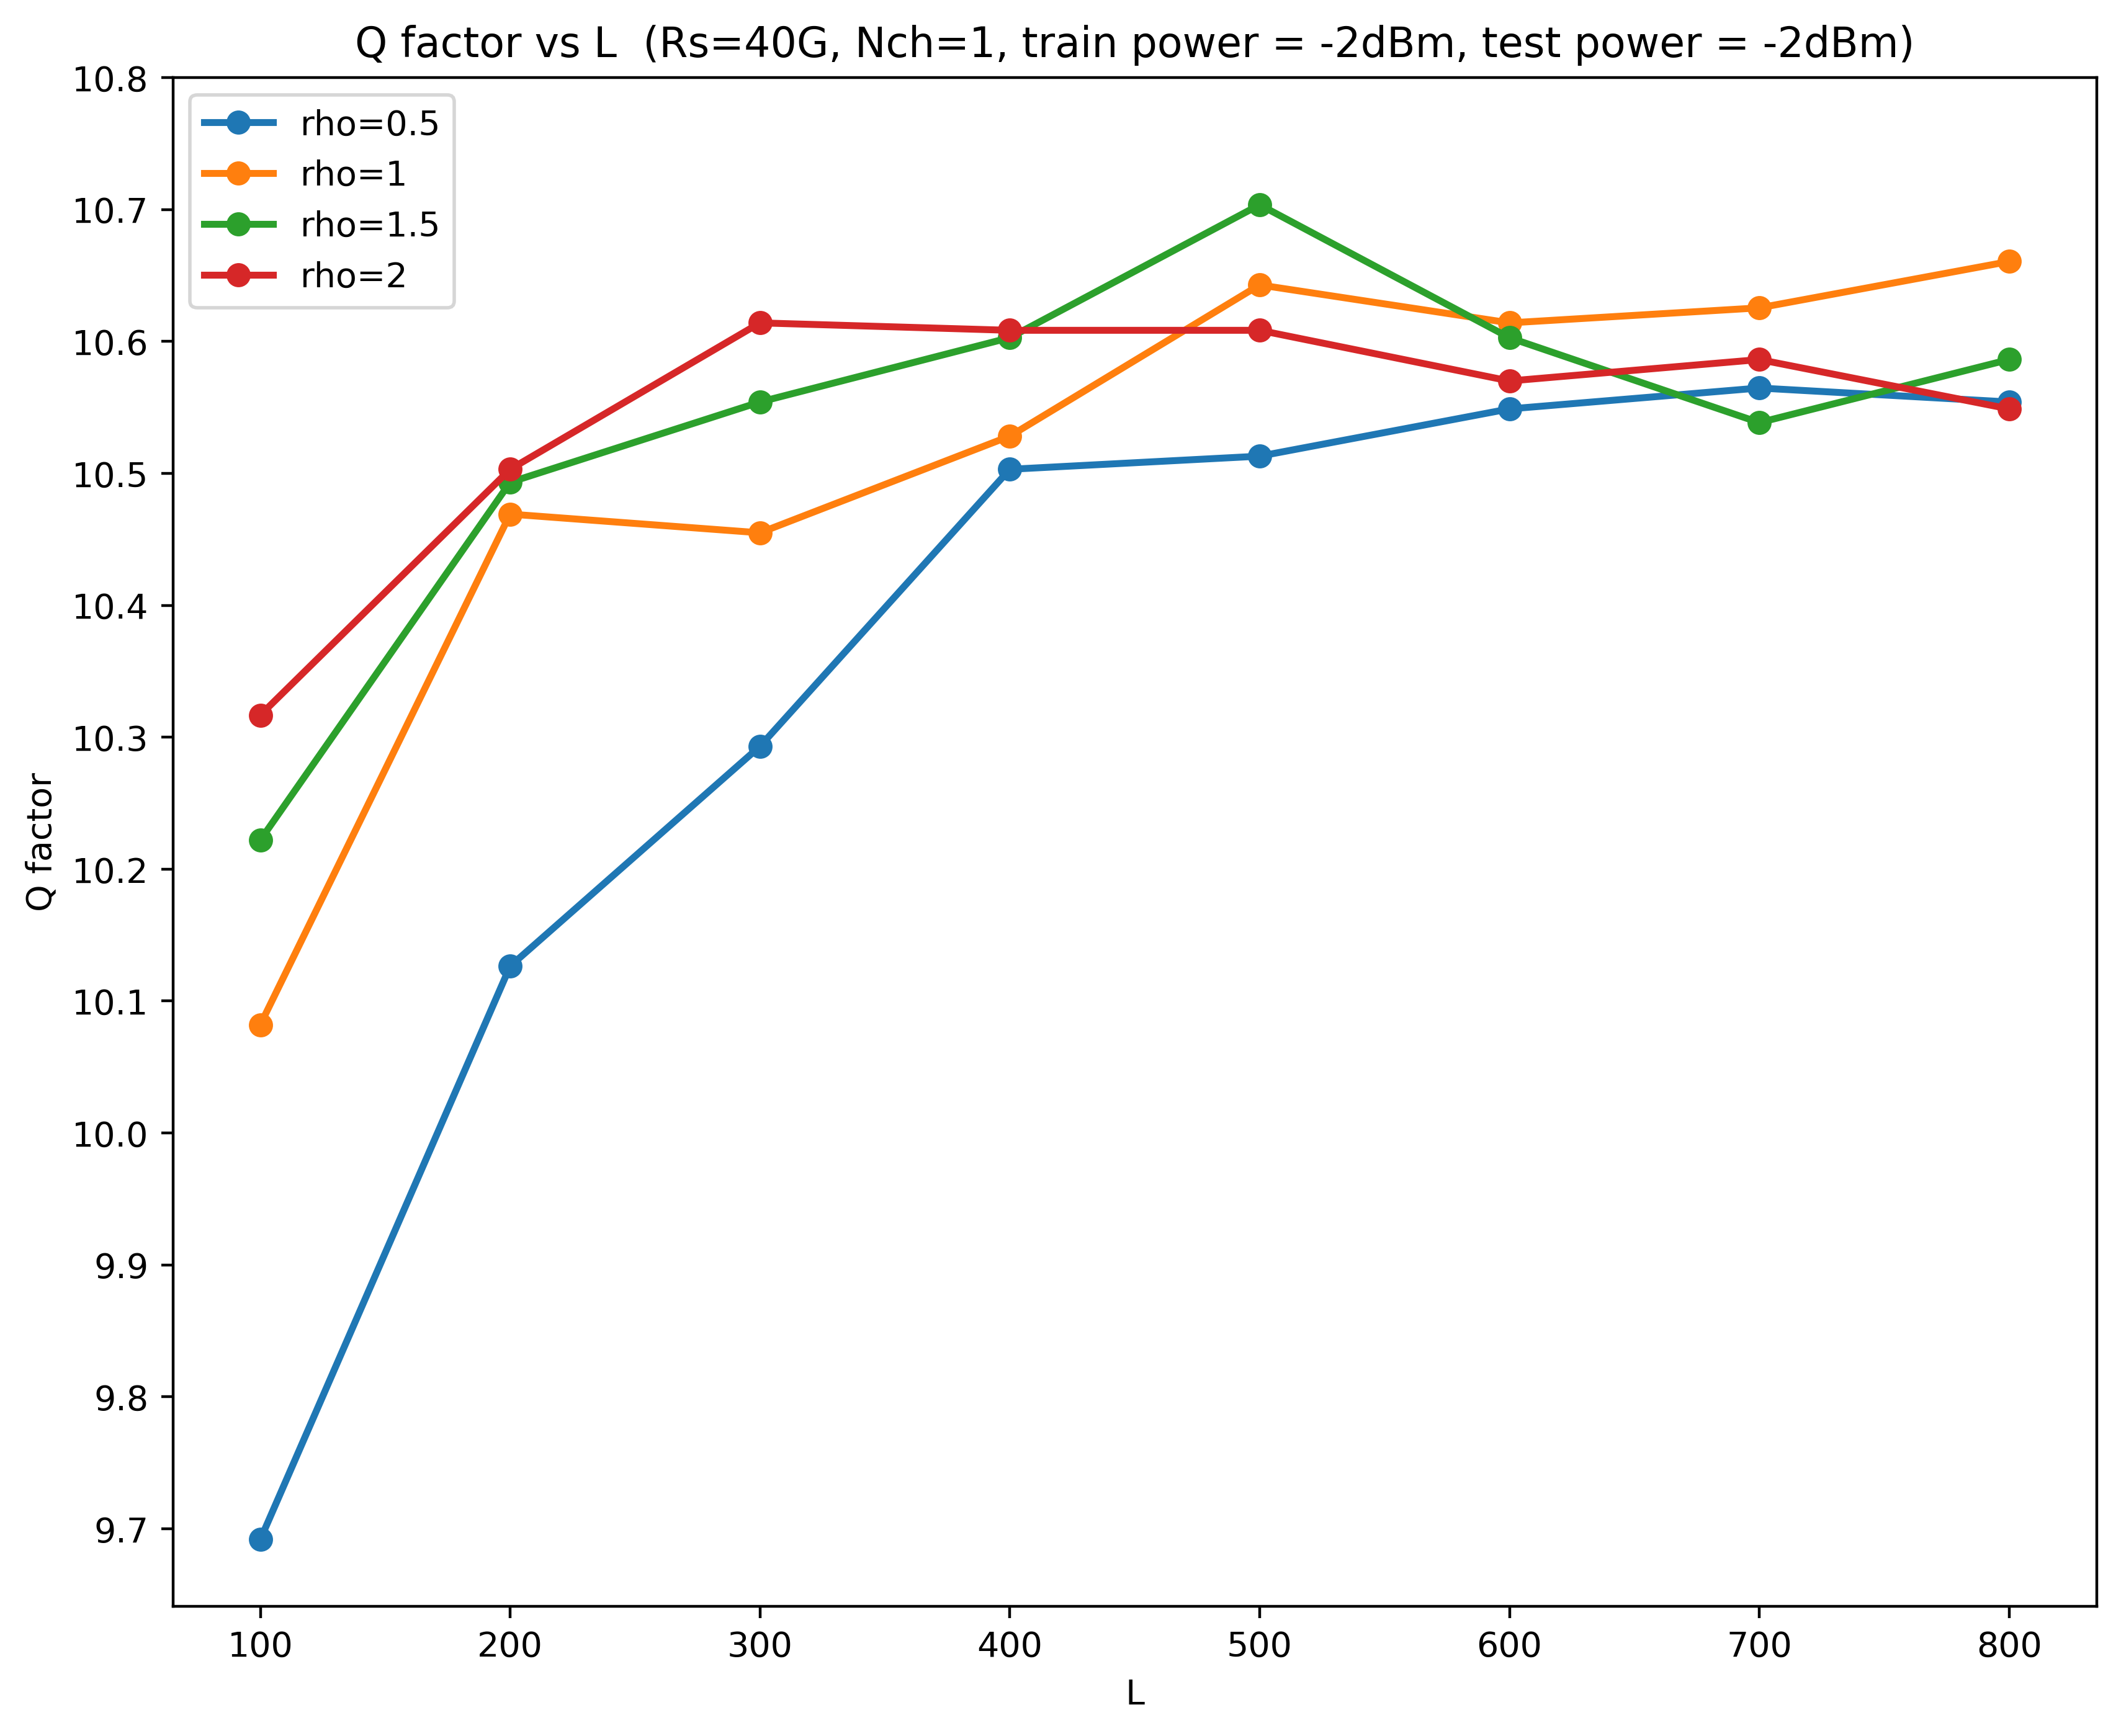

In [7]:
res = pickle.load(open('_outputs/res/res_rho_L_Tr-2_Te-2.pkl', 'rb'))

plt.figure(figsize=(10,8), dpi=400)
Ls = [100, 200, 300, 400, 500, 600, 700, 800]
plt.plot(Ls, [res[f'Q1 rho=0.5, L={L}'] for L in Ls], '-o',linewidth=2, label='rho=0.5')
plt.plot(Ls, [res[f'Q1 rho=1, L={L}'] for L in Ls],'-o',linewidth=2,label='rho=1')
plt.plot(Ls, [res[f'Q1 rho=1.5, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=1.5')
plt.plot(Ls, [res[f'Q1 rho=2, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=2')
plt.xlabel('L')
plt.ylabel('Q factor')
plt.title('Q factor vs L  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')
plt.yticks(np.arange(9.7, 10.8, 0.1))
plt.legend()

In [11]:
res['Q1 rho=1.5, L=500']

10.703516

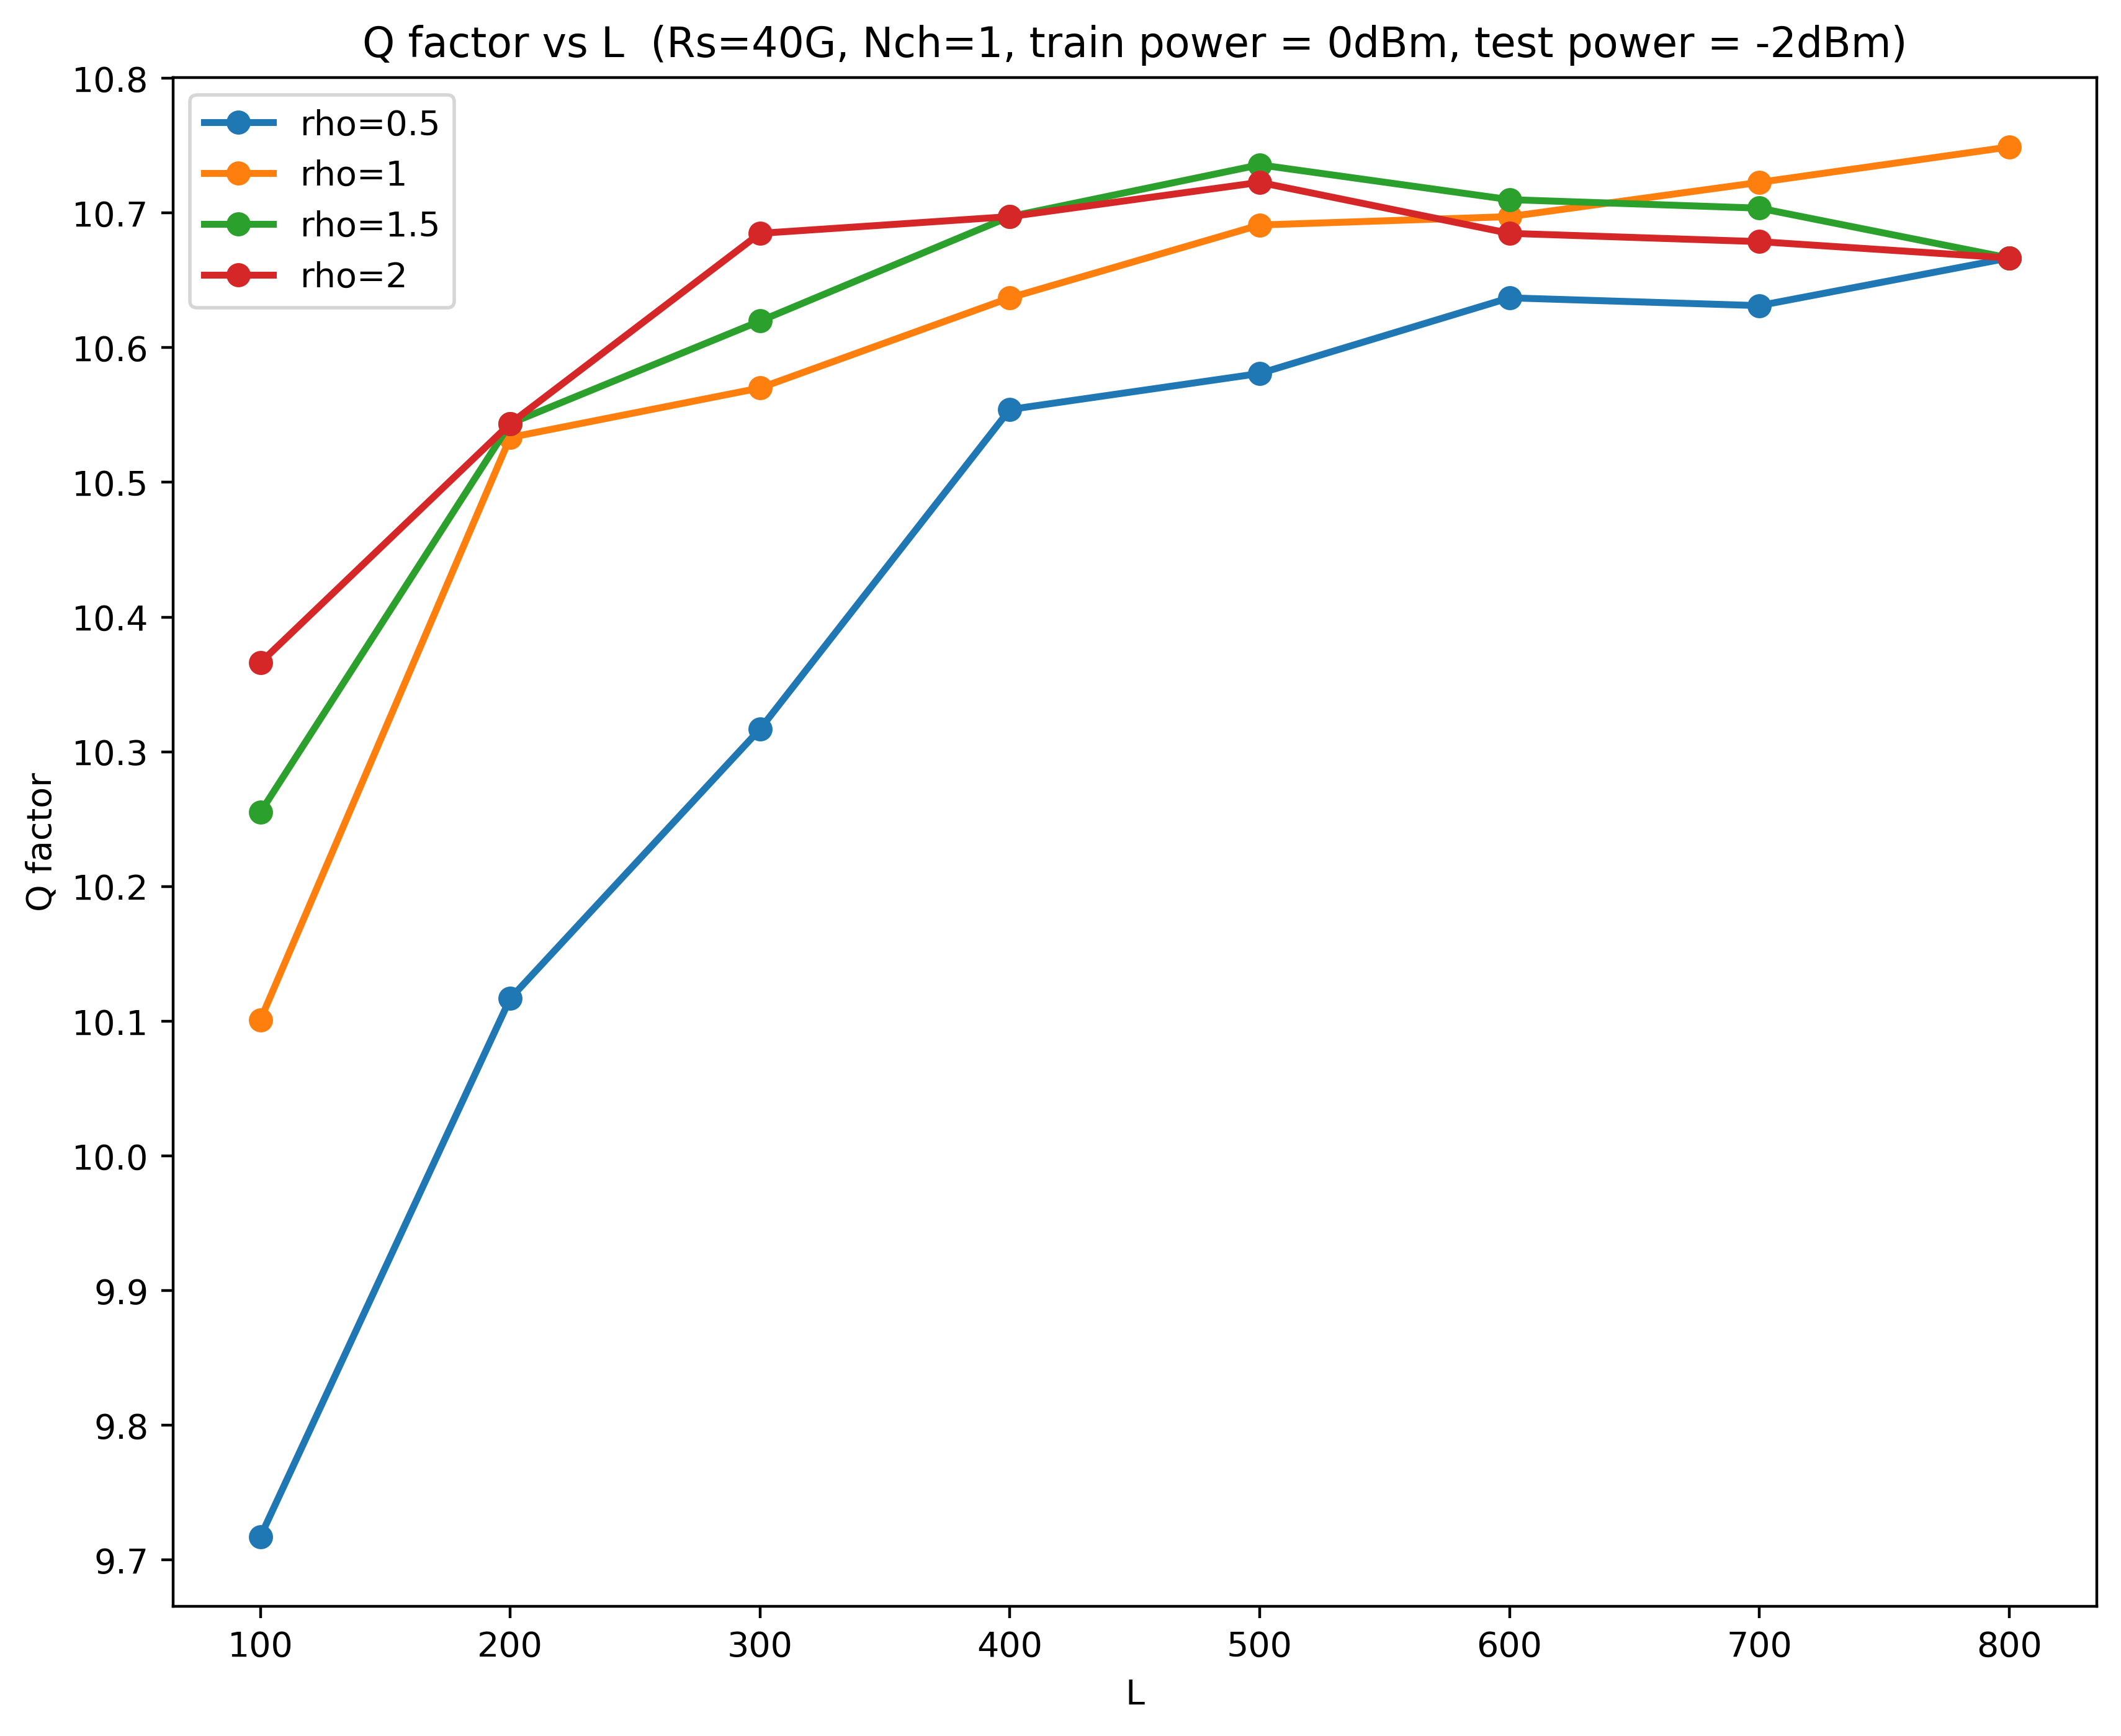

In [12]:
res = pickle.load(open('_outputs/res/res_rho_L_Tr0_Te-2.pkl', 'rb'))

plt.figure(figsize=(10,8), dpi=400)
Ls = [100, 200, 300, 400, 500, 600, 700, 800]
plt.plot(Ls, [res[f'Q1 rho=0.5, L={L}'] for L in Ls], '-o',linewidth=2, label='rho=0.5')
plt.plot(Ls, [res[f'Q1 rho=1, L={L}'] for L in Ls],'-o',linewidth=2,label='rho=1')
plt.plot(Ls, [res[f'Q1 rho=1.5, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=1.5')
plt.plot(Ls, [res[f'Q1 rho=2, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=2')
plt.xlabel('L')
plt.ylabel('Q factor')
plt.title('Q factor vs L  (Rs=40G, Nch=1, train power = 0dBm, test power = -2dBm)')
plt.yticks(np.arange(9.7, 10.8, 0.1))
plt.legend()

Text(0.5, 1.0, 'Q factor vs Data size  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')

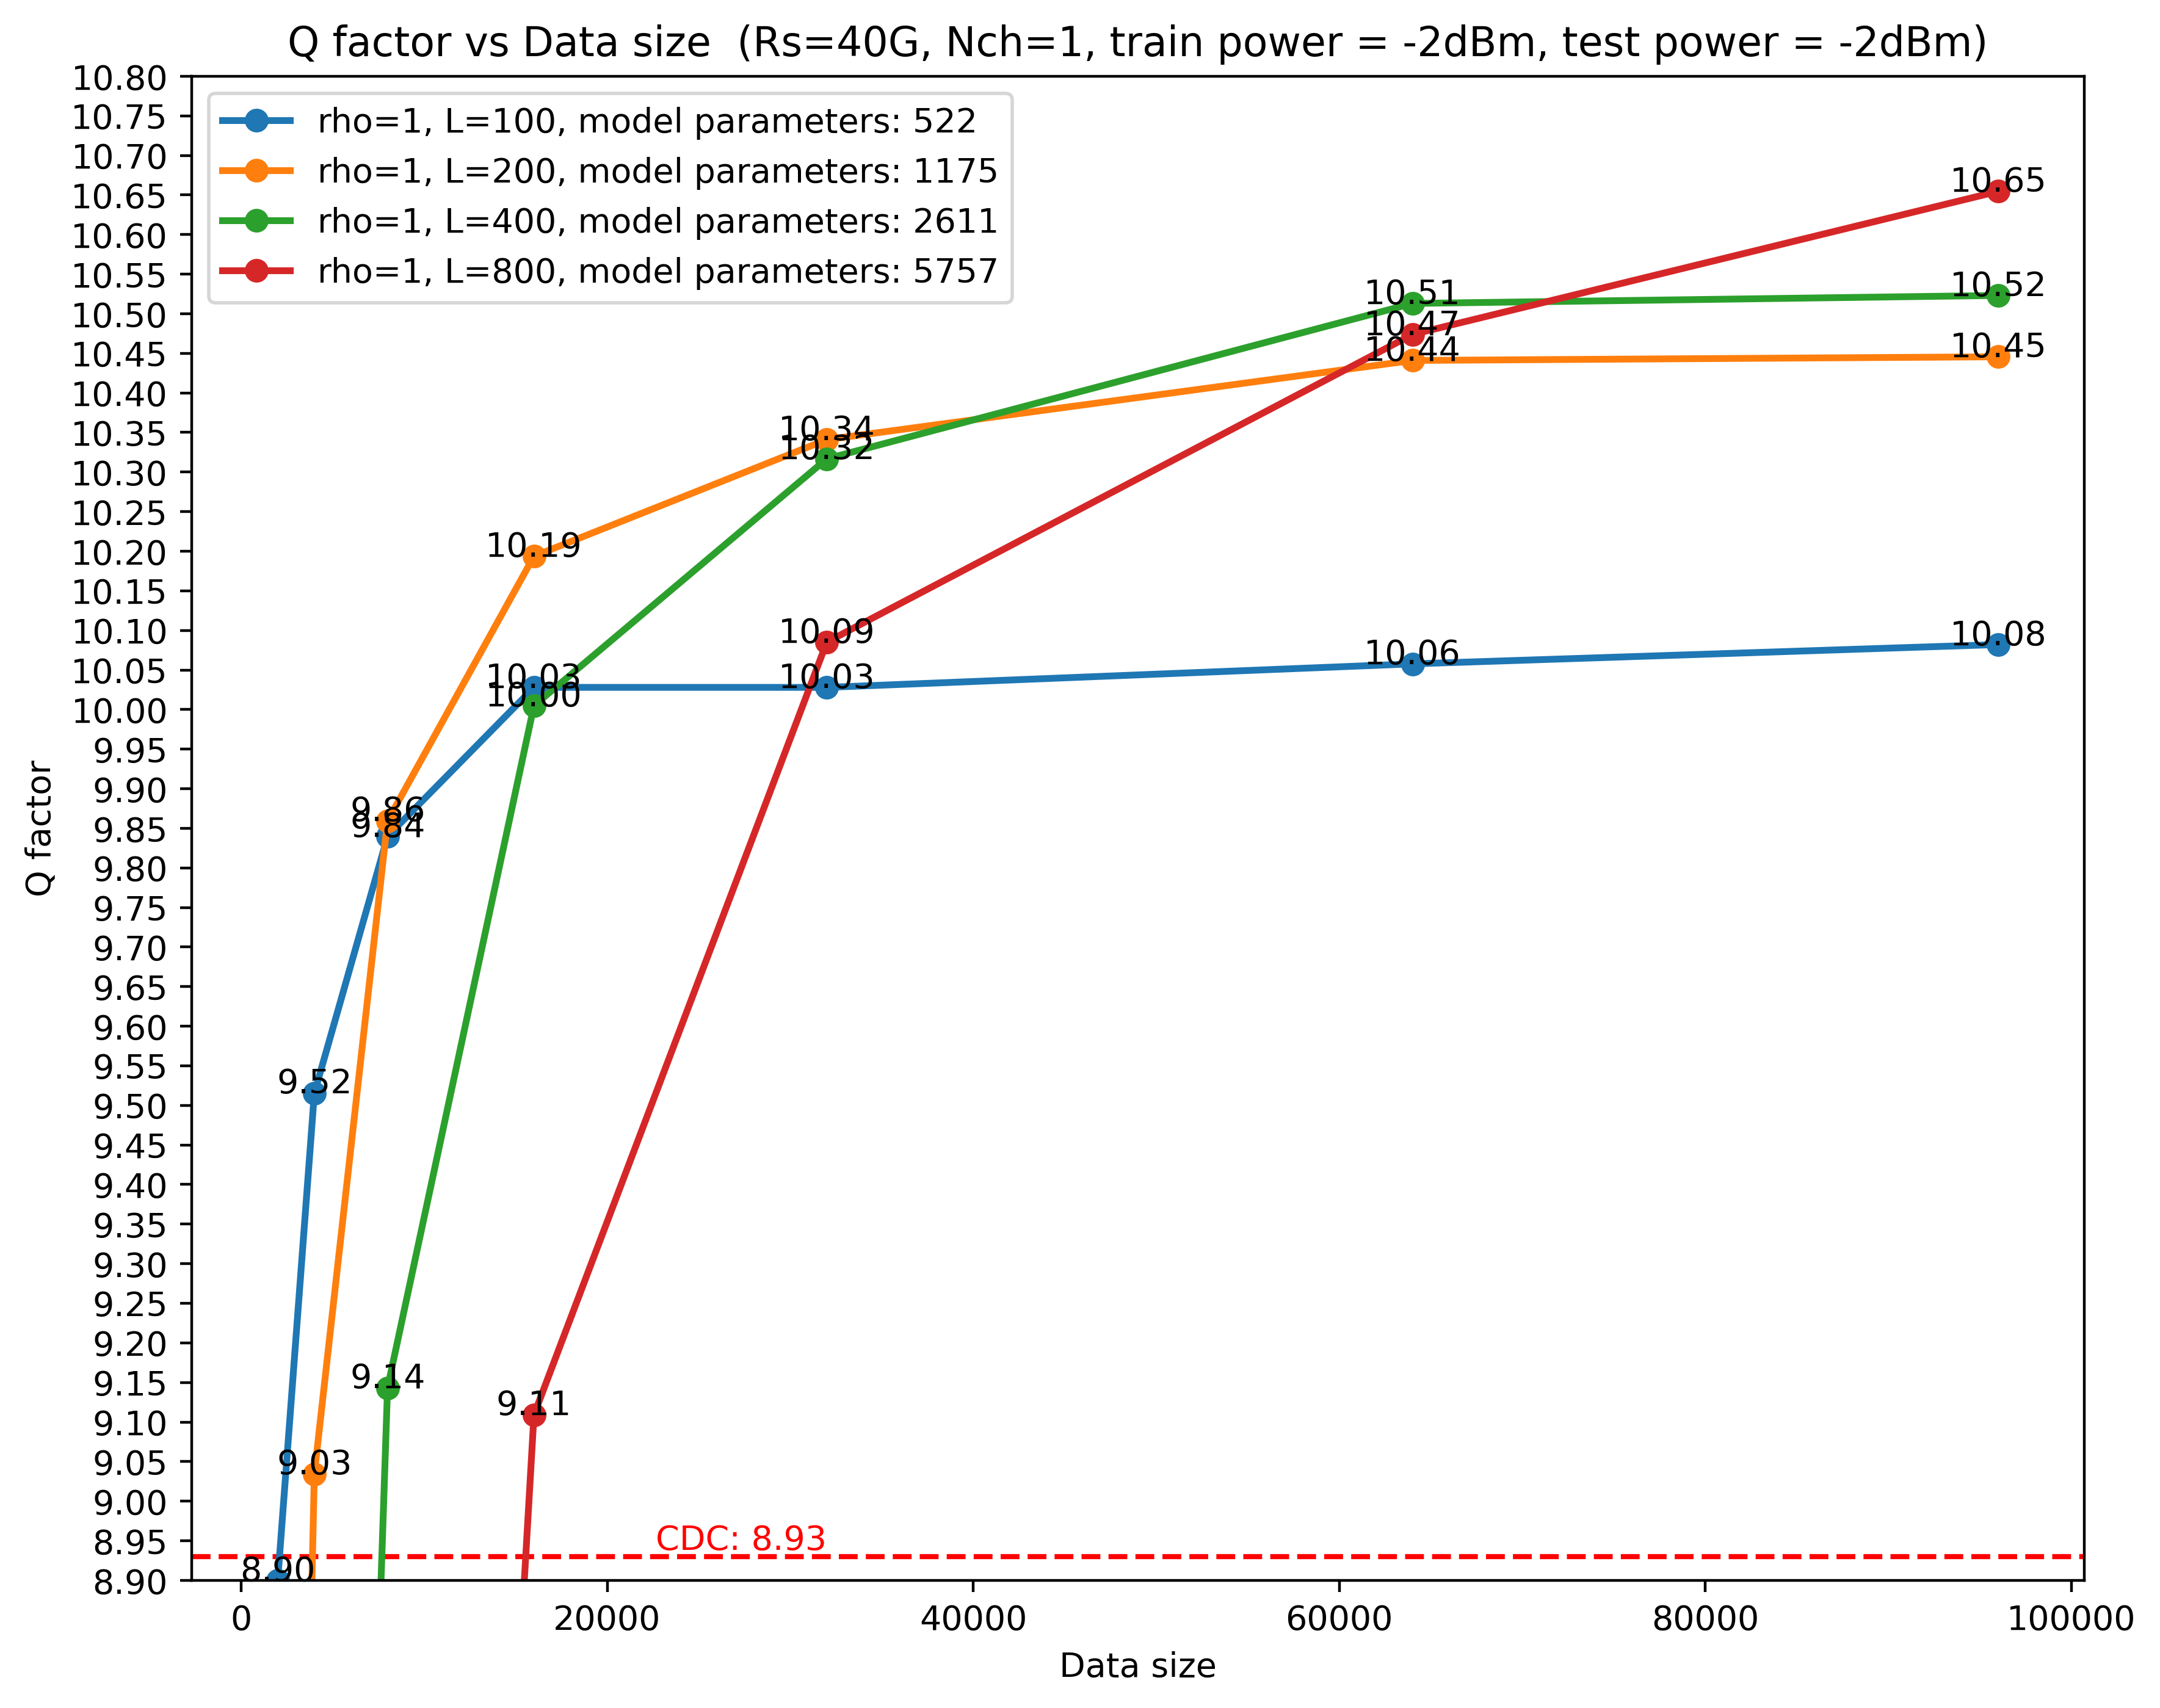

In [84]:
from src.TorchDSP.dataloader import get_Qsq, getQsq_fromdir, mean_peak

plt.figure(figsize=(10,8), dpi=400)
Ds = 2*np.array([1000, 2000, 4000, 8000, 16000, 32000, 48000])
Ls = [100, 200, 400, 800]

# Take CDC result as baseline
Q1,Rs,Nch,P = get_Qsq('./outputs/Qfactor/Q2000/baselines.pkl', discard=10000)
cdc = Q1['CDC'][1, 0,:]
baseline = cdc[6,0]
plt.axhline(y=baseline, color='r', linestyle='--')
plt.text(Ds[4], baseline, f'CDC: {baseline:.2f}', ha='right', va='bottom', color='r')

# Take data and plot
res = pickle.load(open(f'_outputs/res/res_D_L_Tr-2_Te-2.pkl', 'rb'))
y_range = [8.9, 10.8]

for L in Ls:
    Qs = np.array([res[f'Q1 D={d} L={L}'] for d in Ds])                                         # get Qfactor
    p = len(NonlienarFeatures(Nmodes=1, rho=1, L = L, index_type='reduce-1').index)          # calc number of features
    plt.plot(Ds, Qs, '-o',linewidth=2, label=f'rho={1}, L={L}, model parameters: {p}')       # plot

    for i, value in enumerate(Qs):
        if Qs[i] >= y_range[0] and Qs[i] <= y_range[1]:
            plt.text(Ds[i], Qs[i], f'{value:.2f}', ha='center')             # annotate

plt.ylim(*y_range)
plt.yticks(np.arange(*y_range, 0.05))
plt.legend()
plt.xlabel('Data size')
plt.ylabel('Q factor')
plt.title('Q factor vs Data size  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')

Text(0.5, 1.0, 'Q factor vs Data size  (Rs=40G, Nch=1, train power = 0dBm, test power = -2dBm)')

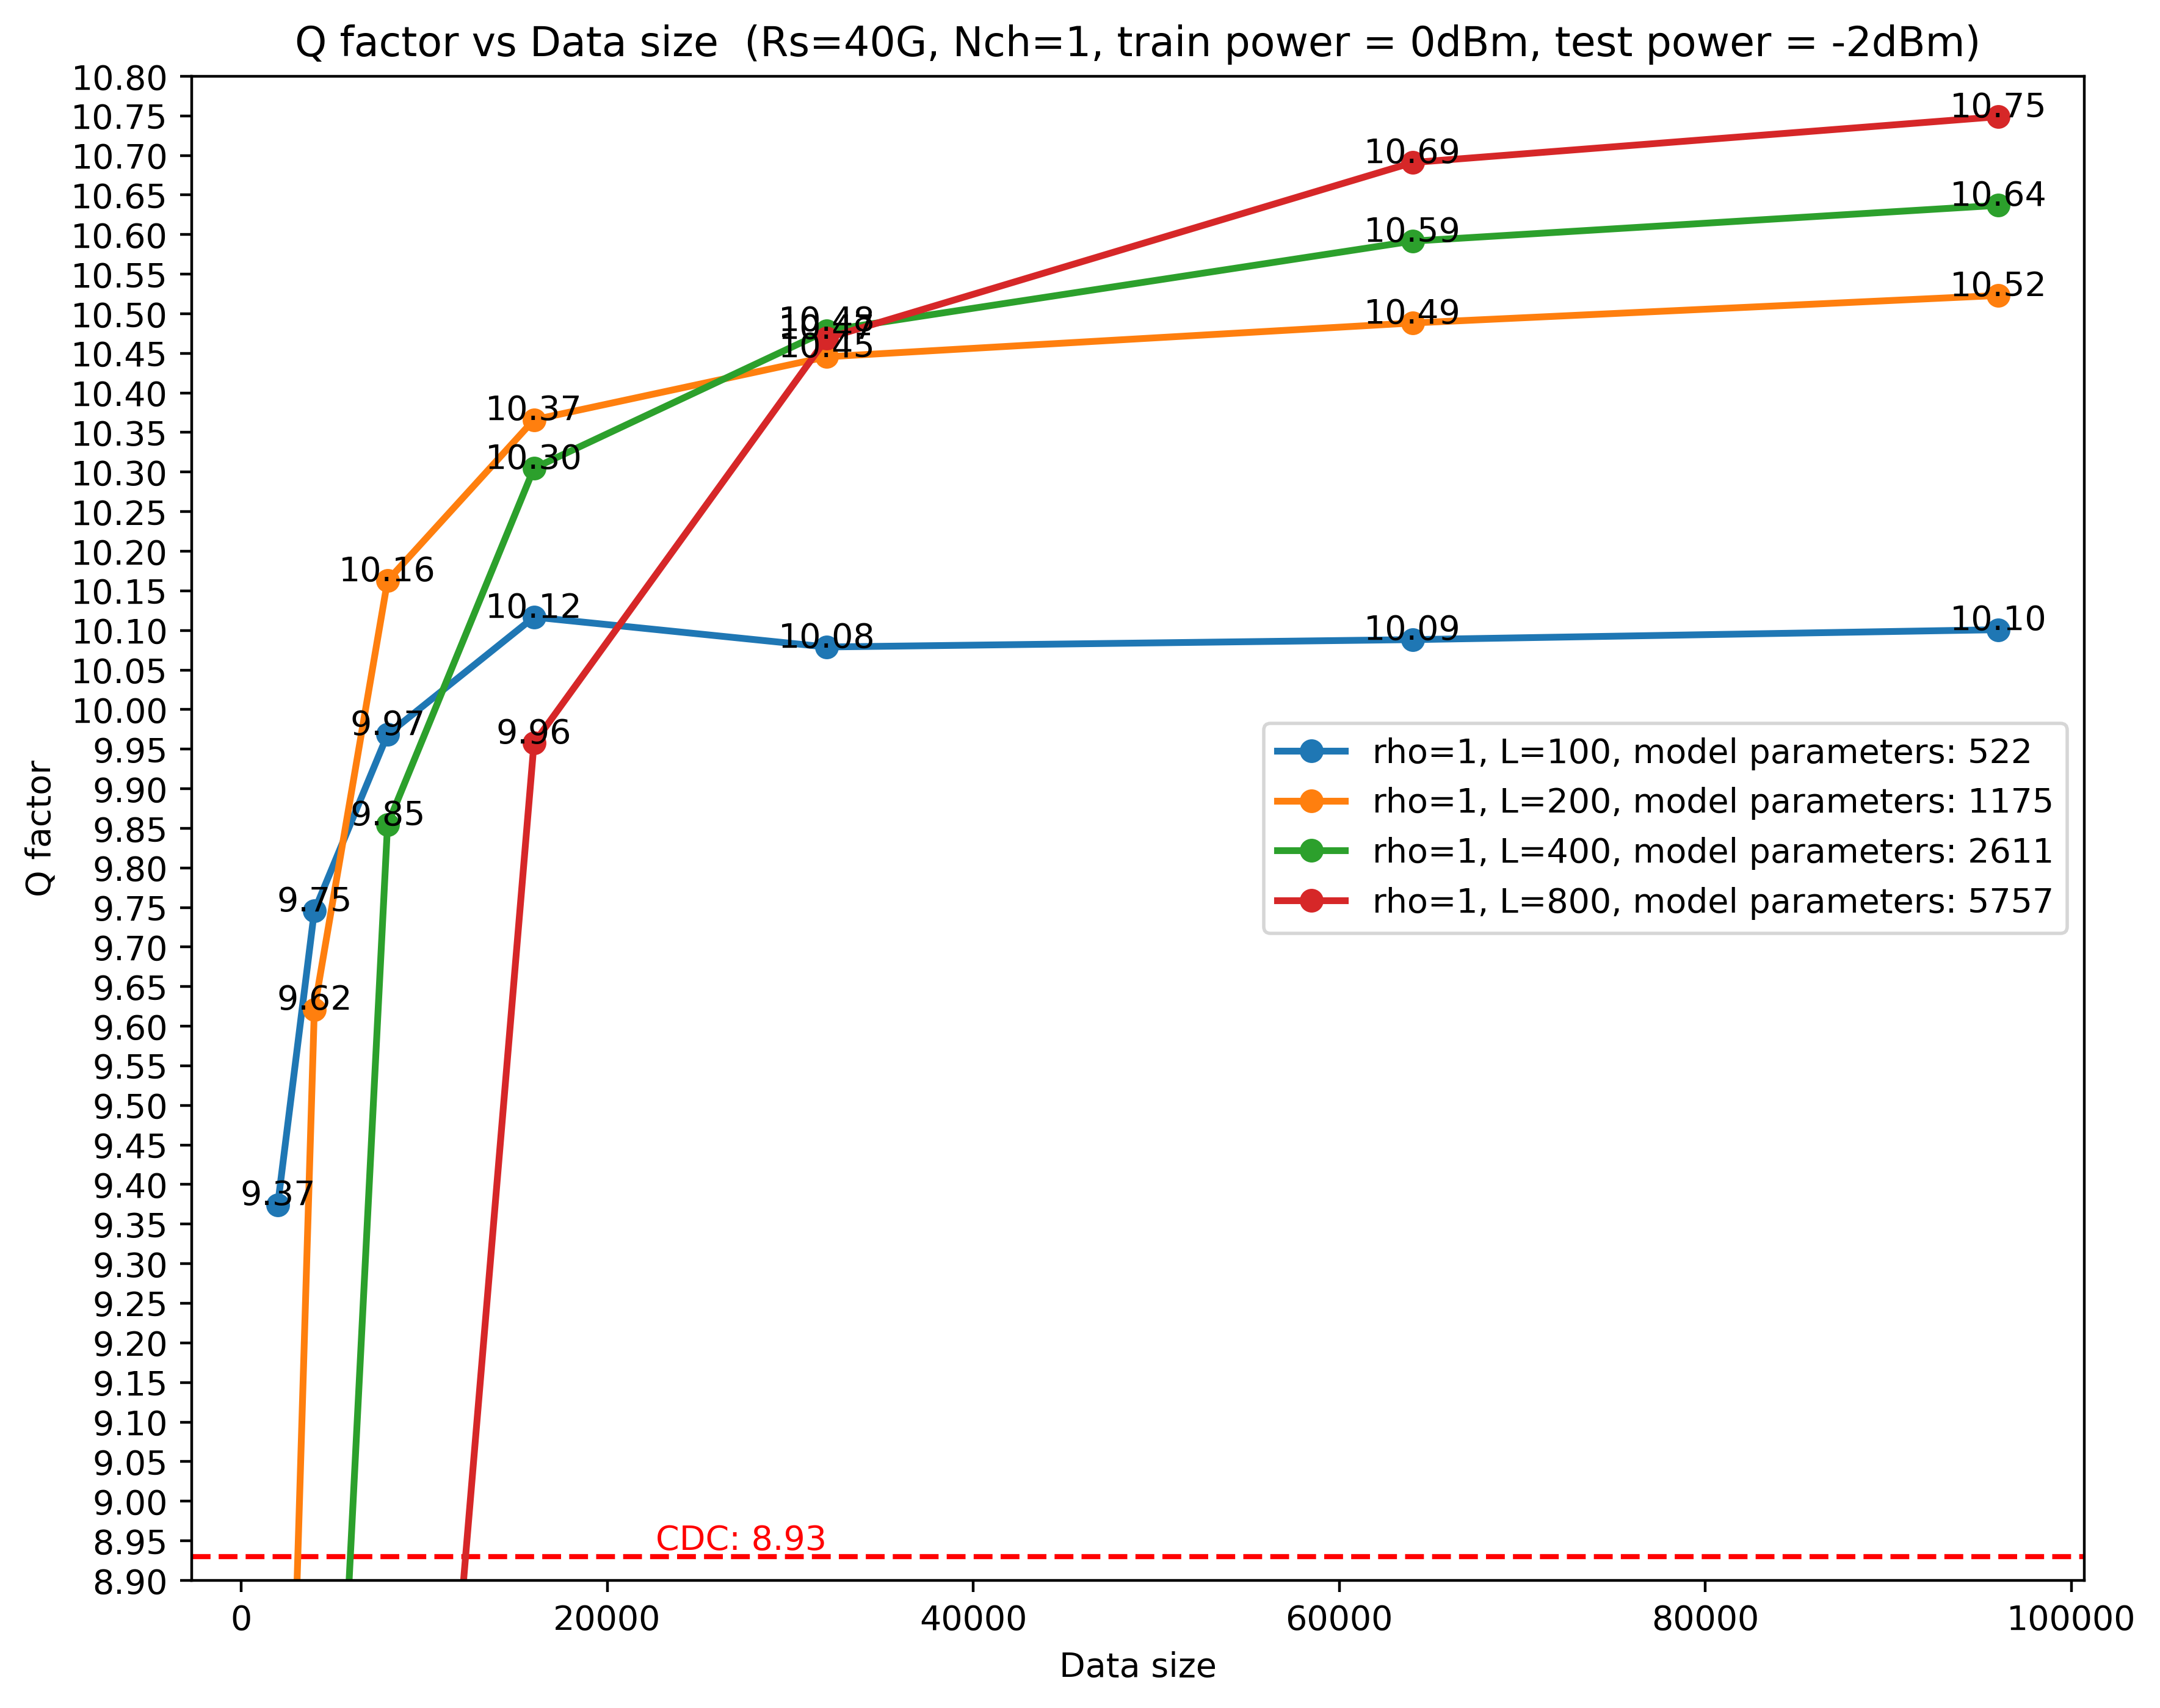

In [85]:
from src.TorchDSP.dataloader import get_Qsq, getQsq_fromdir, mean_peak

plt.figure(figsize=(10,8), dpi=400)
Ds = 2*np.array([1000, 2000, 4000, 8000, 16000, 32000, 48000])
Ls = [100, 200, 400, 800]

# Take CDC result as baseline
Q1,Rs,Nch,P = get_Qsq('./outputs/Qfactor/Q2000/baselines.pkl', discard=10000)
cdc = Q1['CDC'][1, 0,:]
baseline = cdc[6,0]
plt.axhline(y=baseline, color='r', linestyle='--')
plt.text(Ds[4], baseline, f'CDC: {baseline:.2f}', ha='right', va='bottom', color='r')

# Take data and plot
res = pickle.load(open(f'_outputs/res/res_D_L_Tr0_Te-2.pkl', 'rb'))
y_range = [8.9, 10.8]

for L in Ls:
    Qs = np.array([res[f'Q1 D={d} L={L}'] for d in Ds])                                         # get Qfactor
    p = len(NonlienarFeatures(Nmodes=1, rho=1, L = L, index_type='reduce-1').index)          # calc number of features
    plt.plot(Ds, Qs, '-o', linewidth=2, label=f'rho={1}, L={L}, model parameters: {p}')       # plot

    for i, value in enumerate(Qs):
        if Qs[i] >= y_range[0] and Qs[i] <= y_range[1]:
            plt.text(Ds[i], Qs[i], f'{value:.2f}', ha='center')             # annotate

plt.ylim(*y_range)
plt.yticks(np.arange(*y_range, 0.05))
plt.legend()
plt.xlabel('Data size')
plt.ylabel('Q factor')
plt.title('Q factor vs Data size  (Rs=40G, Nch=1, train power = 0dBm, test power = -2dBm)')

# Trainp-test P

In [24]:
res = pickle.load(open('_outputs/res/res_TrTe_L400_D96000.pkl', 'rb'))

P = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3,4,5,6]
Q = np.zeros((len(P), len(P)))

for i, tr in enumerate(P):
    Q[i,:] = res[f'Q1 tr={tr}'][0,:,0]

Text(0, 0.5, 'train power')

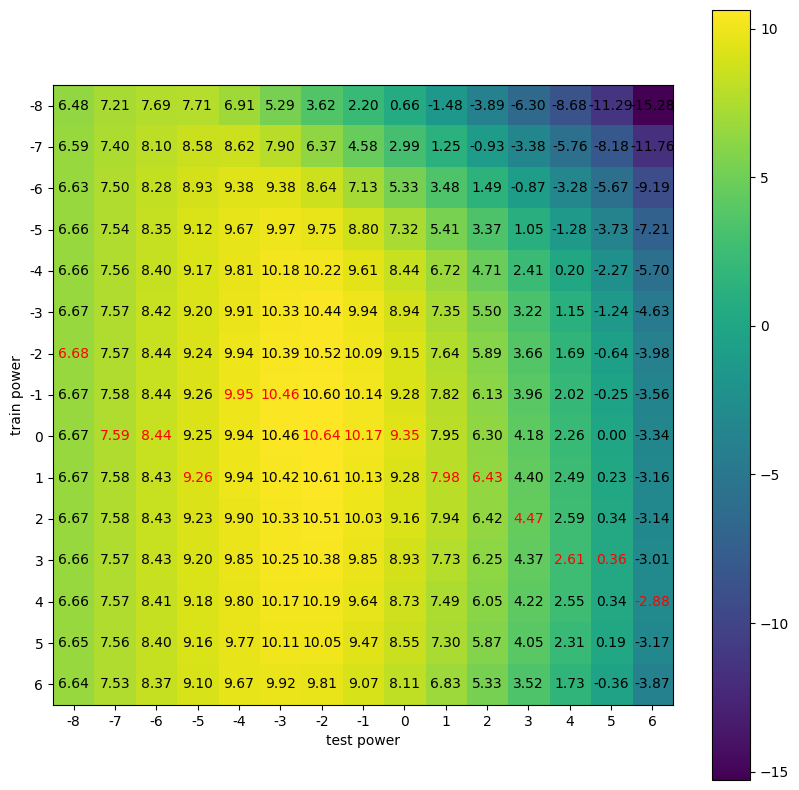

In [28]:
# write the number into each position, index the max value in each column
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(Q, cmap= 'viridis')
# annotate the number
for i in range(len(P)):
    for j in range(len(P)):
        if i == np.argmax(Q, axis=0)[j]:
            plt.text(j, i, f'{Q[i,j]:.2f}', ha='center', va='center', color='r')
        else:
            plt.text(j, i, f'{Q[i,j]:.2f}', ha='center', va='center', color='k')


# # set the color bar range 
# plt.clim(, 10.7)
# add color bar
plt.colorbar()

plt.xticks(np.arange(len(P)), P)
plt.yticks(np.arange(len(P)), P)
plt.xlabel('test power')
plt.ylabel('train power')

# scaling law

In [7]:
import numpy as np, pickle, matplotlib.pyplot as plt
from scipy import special

def Qsq_inv(y):
    return 0.5 * special.erfc(10**(y / 20) / np.sqrt(2))

In [5]:
res = pickle.load(open(f'_outputs/res/res_D_L_Tr0_Te-2.pkl', 'rb'))

Ds = 2*np.array([1000, 2000, 4000, 8000, 16000, 32000, 48000])
Ls =  np.arange(100, 900, 100)

Q = np.zeros([len(Ds), len(Ls)])
Ber = np.zeros([len(Ds), len(Ls)])
for i, d in enumerate(Ds):
    for j, L in enumerate(Ls):
        Q[i,j] = res[f'Q1 D={d} L={L}']
        Ber[i,j] = Qsq_inv(Q[i,j])

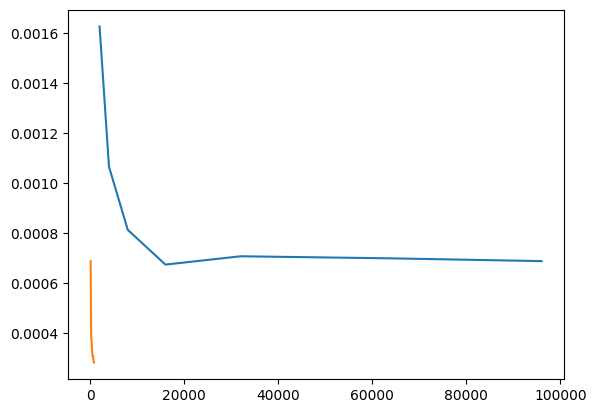

In [9]:
plt.plot(Ds, Ber[:,0])
plt.plot(Ls, Ber[-1])